# Construire un modèle de classification : Délicieuses cuisines asiatiques et indiennes


## Classificateurs de cuisine 1

Dans cette leçon, nous allons explorer une variété de classificateurs pour *prédire une cuisine nationale donnée en fonction d'un groupe d'ingrédients.* Ce faisant, nous découvrirons certaines des façons dont les algorithmes peuvent être utilisés pour des tâches de classification.

### [**Quiz avant le cours**](https://gray-sand-07a10f403.1.azurestaticapps.net/quiz/21/)

### **Préparation**

Cette leçon s'appuie sur notre [leçon précédente](https://github.com/microsoft/ML-For-Beginners/blob/main/4-Classification/1-Introduction/solution/lesson_10-R.ipynb) où nous avons :

-   Fait une introduction douce aux classifications en utilisant un jeu de données sur toutes les brillantes cuisines d'Asie et d'Inde 😋.

-   Exploré quelques [verbes dplyr](https://dplyr.tidyverse.org/) pour préparer et nettoyer nos données.

-   Réalisé de belles visualisations avec ggplot2.

-   Montré comment gérer des données déséquilibrées en les prétraitant avec [recipes](https://recipes.tidymodels.org/articles/Simple_Example.html).

-   Démontré comment `prep` et `bake` notre recette pour confirmer qu'elle fonctionne comme prévu.

#### **Prérequis**

Pour cette leçon, nous aurons besoin des packages suivants pour nettoyer, préparer et visualiser nos données :

-   `tidyverse` : Le [tidyverse](https://www.tidyverse.org/) est une [collection de packages R](https://www.tidyverse.org/packages) conçue pour rendre la science des données plus rapide, plus facile et plus amusante !

-   `tidymodels` : Le framework [tidymodels](https://www.tidymodels.org/) est une [collection de packages](https://www.tidymodels.org/packages/) pour la modélisation et l'apprentissage automatique.

-   `themis` : Le package [themis](https://themis.tidymodels.org/) fournit des étapes supplémentaires pour les recettes afin de gérer les données déséquilibrées.

-   `nnet` : Le package [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf) propose des fonctions pour estimer des réseaux de neurones à propagation avant avec une seule couche cachée, ainsi que des modèles de régression logistique multinomiale.

Vous pouvez les installer comme suit :


`install.packages(c("tidyverse", "tidymodels", "DataExplorer", "here"))`

Alternativement, le script ci-dessous vérifie si vous avez les packages nécessaires pour compléter ce module et les installe pour vous s'ils sont manquants.


In [2]:
suppressWarnings(if (!require("pacman"))install.packages("pacman"))

pacman::p_load(tidyverse, tidymodels, themis, here)

Loading required package: pacman



## 1. Divisez les données en ensembles d'entraînement et de test.

Commençons par reprendre quelques étapes de notre leçon précédente.

### Supprimez les ingrédients les plus courants qui créent de la confusion entre les cuisines distinctes, en utilisant `dplyr::select()`.

Tout le monde adore le riz, l'ail et le gingembre !


In [3]:
# Load the original cuisines data
df <- read_csv(file = "https://raw.githubusercontent.com/microsoft/ML-For-Beginners/main/4-Classification/data/cuisines.csv")

# Drop id column, rice, garlic and ginger from our original data set
df_select <- df %>% 
  select(-c(1, rice, garlic, ginger)) %>%
  # Encode cuisine column as categorical
  mutate(cuisine = factor(cuisine))

# Display new data set
df_select %>% 
  slice_head(n = 5)

# Display distribution of cuisines
df_select %>% 
  count(cuisine) %>% 
  arrange(desc(n))

New names:
* `` -> ...1

Rows: 2448 Columns: 385

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (1): cuisine
dbl (384): ...1, almond, angelica, anise, anise_seed, apple, apple_brandy, a...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 indian  0      0        0     0          0     0            0       0       
2 indian  1      0        0     0          0     0            0       0       
3 indian  0      0        0     0          0     0            0       0       
4 indian  0      0        0     0          0     0            0       0       
5 indian  0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       0    0   
2 0         ⋯ 0       0           0          0                       0    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     1      0

cuisine  n  
1 korean   799
2 indian   598
3 chinese  442
4 japanese 320
5 thai     289

Parfait ! Maintenant, il est temps de diviser les données de manière à ce que 70 % des données soient utilisées pour l'entraînement et 30 % pour les tests. Nous appliquerons également une technique de `stratification` lors de la division des données afin de `maintenir la proportion de chaque cuisine` dans les ensembles de données d'entraînement et de validation.

[rsample](https://rsample.tidymodels.org/), un package de Tidymodels, offre une infrastructure pour une division et un échantillonnage efficaces des données :


In [4]:
# Load the core Tidymodels packages into R session
library(tidymodels)

# Create split specification
set.seed(2056)
cuisines_split <- initial_split(data = df_select,
                                strata = cuisine,
                                prop = 0.7)

# Extract the data in each split
cuisines_train <- training(cuisines_split)
cuisines_test <- testing(cuisines_split)

# Print the number of cases in each split
cat("Training cases: ", nrow(cuisines_train), "\n",
    "Test cases: ", nrow(cuisines_test), sep = "")

# Display the first few rows of the training set
cuisines_train %>% 
  slice_head(n = 5)


# Display distribution of cuisines in the training set
cuisines_train %>% 
  count(cuisine) %>% 
  arrange(desc(n))

Training cases: 1712
Test cases: 736

cuisine almond angelica anise anise_seed apple apple_brandy apricot armagnac
1 chinese 0      0        0     0          0     0            0       0       
2 chinese 0      0        0     0          0     0            0       0       
3 chinese 0      0        0     0          0     0            0       0       
4 chinese 0      0        0     0          0     0            0       0       
5 chinese 0      0        0     0          0     0            0       0       
  artemisia ⋯ whiskey white_bread white_wine whole_grain_wheat_flour wine wood
1 0         ⋯ 0       0           0          0                       1    0   
2 0         ⋯ 0       0           0          0                       1    0   
3 0         ⋯ 0       0           0          0                       0    0   
4 0         ⋯ 0       0           0          0                       0    0   
5 0         ⋯ 0       0           0          0                       0    0   
  yam yeast yogurt zucchini
1 0   0     0      0       
2 0   0     0      0       
3 0   0     0      0       
4 0   0     0      0       
5 0   0     0      0

cuisine  n  
1 korean   559
2 indian   418
3 chinese  309
4 japanese 224
5 thai     202

## 2. Gérer les données déséquilibrées

Comme vous avez peut-être remarqué dans le jeu de données original ainsi que dans notre ensemble d'entraînement, il y a une distribution assez inégale dans le nombre de cuisines. Les cuisines coréennes sont *presque* 3 fois plus nombreuses que les cuisines thaïlandaises. Les données déséquilibrées ont souvent des effets négatifs sur les performances du modèle. De nombreux modèles fonctionnent mieux lorsque le nombre d'observations est équilibré et, par conséquent, ont tendance à rencontrer des difficultés avec des données déséquilibrées.

Il existe principalement deux façons de gérer des ensembles de données déséquilibrés :

-   ajouter des observations à la classe minoritaire : `Sur-échantillonnage`, par exemple en utilisant un algorithme SMOTE qui génère de manière synthétique de nouveaux exemples de la classe minoritaire en utilisant les plus proches voisins de ces cas.

-   supprimer des observations de la classe majoritaire : `Sous-échantillonnage`

Dans notre leçon précédente, nous avons démontré comment gérer des ensembles de données déséquilibrés en utilisant une `recette`. Une recette peut être considérée comme un plan décrivant les étapes à appliquer à un ensemble de données pour le préparer à l'analyse. Dans notre cas, nous souhaitons obtenir une distribution égale du nombre de nos cuisines pour notre `ensemble d'entraînement`. Passons directement à la pratique.


In [5]:
# Load themis package for dealing with imbalanced data
library(themis)

# Create a recipe for preprocessing training data
cuisines_recipe <- recipe(cuisine ~ ., data = cuisines_train) %>% 
  step_smote(cuisine)

# Print recipe
cuisines_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor        380

Operations:

SMOTE based on cuisine

Vous pouvez bien sûr confirmer (en utilisant prep+bake) que la recette fonctionnera comme prévu - toutes les étiquettes de cuisine ayant `559` observations.

Étant donné que nous utiliserons cette recette comme préprocesseur pour la modélisation, un `workflow()` effectuera tout le travail de préparation et de cuisson pour nous, donc nous n'aurons pas à estimer manuellement la recette.

Nous sommes maintenant prêts à entraîner un modèle 👩‍💻👨‍💻 !

## 3. Choisir votre classificateur

<p >
   <img src="../../images/parsnip.jpg"
   width="600"/>
   <figcaption>Illustration par @allison_horst</figcaption>


Maintenant, nous devons décider quel algorithme utiliser pour cette tâche 🤔.

Dans Tidymodels, le [`package parsnip`](https://parsnip.tidymodels.org/index.html) offre une interface cohérente pour travailler avec des modèles à travers différents moteurs (packages). Veuillez consulter la documentation de parsnip pour explorer les [types de modèles et moteurs](https://www.tidymodels.org/find/parsnip/#models) ainsi que leurs [arguments de modèles correspondants](https://www.tidymodels.org/find/parsnip/#model-args). La variété peut sembler déroutante au premier abord. Par exemple, les méthodes suivantes incluent toutes des techniques de classification :

-   Modèles de classification basés sur des règles C5.0

-   Modèles discriminants flexibles

-   Modèles discriminants linéaires

-   Modèles discriminants régularisés

-   Modèles de régression logistique

-   Modèles de régression multinomiale

-   Modèles de Bayes naïfs

-   Machines à vecteurs de support

-   Plus proches voisins

-   Arbres de décision

-   Méthodes d'ensemble

-   Réseaux de neurones

Et la liste continue !

### **Quel classifieur choisir ?**

Alors, quel classifieur devriez-vous choisir ? Souvent, tester plusieurs modèles et rechercher un bon résultat est une méthode pour évaluer.

> AutoML résout ce problème de manière élégante en effectuant ces comparaisons dans le cloud, vous permettant de choisir le meilleur algorithme pour vos données. Essayez-le [ici](https://docs.microsoft.com/learn/modules/automate-model-selection-with-azure-automl/?WT.mc_id=academic-77952-leestott)

Le choix du classifieur dépend également de notre problème. Par exemple, lorsque le résultat peut être catégorisé en `plus de deux classes`, comme dans notre cas, vous devez utiliser un `algorithme de classification multiclasses` plutôt qu'une `classification binaire.`

### **Une meilleure approche**

Une meilleure approche que de deviner au hasard est de suivre les idées présentées dans cette [fiche pratique ML téléchargeable](https://docs.microsoft.com/azure/machine-learning/algorithm-cheat-sheet?WT.mc_id=academic-77952-leestott). Ici, nous découvrons que, pour notre problème multiclasses, nous avons plusieurs options :

<p >
   <img src="../../images/cheatsheet.png"
   width="500"/>
   <figcaption>Une section de la fiche pratique des algorithmes de Microsoft, détaillant les options de classification multiclasses</figcaption>


### **Raisonnement**

Voyons si nous pouvons réfléchir à différentes approches en fonction des contraintes que nous avons :

-   **Les réseaux neuronaux profonds sont trop lourds**. Étant donné notre ensemble de données propre mais minimal, et le fait que nous exécutons l'entraînement localement via des notebooks, les réseaux neuronaux profonds sont trop lourds pour cette tâche.

-   **Pas de classificateur à deux classes**. Nous n'utilisons pas de classificateur à deux classes, ce qui exclut l'approche un-contre-tous.

-   **Un arbre de décision ou une régression logistique pourraient fonctionner**. Un arbre de décision pourrait convenir, ou une régression multinomiale/régression logistique multiclasses pour des données multiclasses.

-   **Les arbres de décision multiclasses boostés résolvent un problème différent**. L'arbre de décision multiclasses boosté est le plus adapté aux tâches non paramétriques, par exemple les tâches conçues pour établir des classements, donc il ne nous est pas utile.

En général, avant de se lancer dans des modèles d'apprentissage automatique plus complexes, comme les méthodes d'ensemble, il est judicieux de construire le modèle le plus simple possible pour avoir une idée de ce qui se passe. Donc, pour cette leçon, nous commencerons par un modèle de `régression multinomiale`.

> La régression logistique est une technique utilisée lorsque la variable de résultat est catégorielle (ou nominale). Pour la régression logistique binaire, le nombre de variables de résultat est de deux, tandis que pour la régression logistique multinomiale, le nombre de variables de résultat est supérieur à deux. Voir [Méthodes de régression avancées](https://bookdown.org/chua/ber642_advanced_regression/multinomial-logistic-regression.html) pour en savoir plus.

## 4. Entraîner et évaluer un modèle de régression logistique multinomiale.

Dans Tidymodels, `parsnip::multinom_reg()` définit un modèle qui utilise des prédicteurs linéaires pour prédire des données multiclasses en utilisant la distribution multinomiale. Consultez `?multinom_reg()` pour découvrir les différentes façons/moteurs que vous pouvez utiliser pour ajuster ce modèle.

Pour cet exemple, nous ajusterons un modèle de régression multinomiale via le moteur par défaut [nnet](https://cran.r-project.org/web/packages/nnet/nnet.pdf).

> J'ai choisi une valeur pour `penalty` un peu au hasard. Il existe de meilleures façons de choisir cette valeur, notamment en utilisant la `validation croisée` et en `ajustant` le modèle, ce que nous aborderons plus tard.
>
> Consultez [Tidymodels : Commencer](https://www.tidymodels.org/start/tuning/) si vous souhaitez en savoir plus sur l'ajustement des hyperparamètres du modèle.


In [6]:
# Create a multinomial regression model specification
mr_spec <- multinom_reg(penalty = 1) %>% 
  set_engine("nnet", MaxNWts = 2086) %>% 
  set_mode("classification")

# Print model specification
mr_spec

Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Excellent travail 🥳 ! Maintenant que nous avons une recette et une spécification de modèle, nous devons trouver un moyen de les regrouper dans un objet qui prétraitera d'abord les données, puis ajustera le modèle sur les données prétraitées, tout en permettant également des activités de post-traitement potentielles. Dans Tidymodels, cet objet pratique s'appelle un [`workflow`](https://workflows.tidymodels.org/) et contient commodément vos composants de modélisation ! C'est ce que nous appellerions des *pipelines* en *Python*.

Alors, regroupons tout dans un workflow !📦


In [7]:
# Bundle recipe and model specification
mr_wf <- workflow() %>% 
  add_recipe(cuisines_recipe) %>% 
  add_model(mr_spec)

# Print out workflow
mr_wf

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Multinomial Regression Model Specification (classification)

Main Arguments:
  penalty = 1

Engine-Specific Arguments:
  MaxNWts = 2086

Computational engine: nnet 


Les flux de travail 👌👌 ! Un **`workflow()`** peut être ajusté de la même manière qu'un modèle. Alors, il est temps d'entraîner un modèle !


In [8]:
# Train a multinomial regression model
mr_fit <- fit(object = mr_wf, data = cuisines_train)

mr_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: multinom_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
1 Recipe Step

• step_smote()

── Model ───────────────────────────────────────────────────────────────────────
Call:
nnet::multinom(formula = ..y ~ ., data = data, decay = ~1, MaxNWts = ~2086, 
    trace = FALSE)

Coefficients:
         (Intercept)     almond angelica         anise anise_seed       apple
indian    0.19723325  0.2409661        0 -5.004955e-05 -0.1657635 -0.05769734
japanese  0.13961959 -0.6262400        0 -1.169155e-04 -0.4893596 -0.08585717
korean    0.22377347 -0.1833485        0 -5.560395e-05 -0.2489401 -0.15657804
thai     -0.04336577 -0.6106258        0  4.903828e-04 -0.5782866  0.63451105
         apple_brandy     apricot armagnac   artemisia artichoke   asparagus
indian              0  0.37042636        0 -0.09122797         0 -0.27181970
japanese            0

Les résultats affichent les coefficients que le modèle a appris pendant l'entraînement.

### Évaluer le modèle entraîné

Il est temps de voir comment le modèle s'est comporté 📏 en l'évaluant sur un jeu de test ! Commençons par faire des prédictions sur le jeu de test.


In [9]:
# Make predictions on the test set
results <- cuisines_test %>% select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test))

# Print out results
results %>% 
  slice_head(n = 5)

cuisine .pred_class
1 indian  thai       
2 indian  indian     
3 indian  indian     
4 indian  indian     
5 indian  indian

Beau travail ! Dans Tidymodels, l'évaluation des performances des modèles peut être effectuée à l'aide de [yardstick](https://yardstick.tidymodels.org/) - un package utilisé pour mesurer l'efficacité des modèles à l'aide de métriques de performance. Comme nous l'avons fait dans notre leçon sur la régression logistique, commençons par calculer une matrice de confusion.


In [10]:
# Confusion matrix for categorical data
conf_mat(data = results, truth = cuisine, estimate = .pred_class)


          Truth
Prediction chinese indian japanese korean thai
  chinese       83      1        8     15   10
  indian         4    163        1      2    6
  japanese      21      5       73     25    1
  korean        15      0       11    191    0
  thai          10     11        3      7   70

Lorsqu'on traite plusieurs classes, il est généralement plus intuitif de visualiser cela comme une carte thermique, comme ceci :


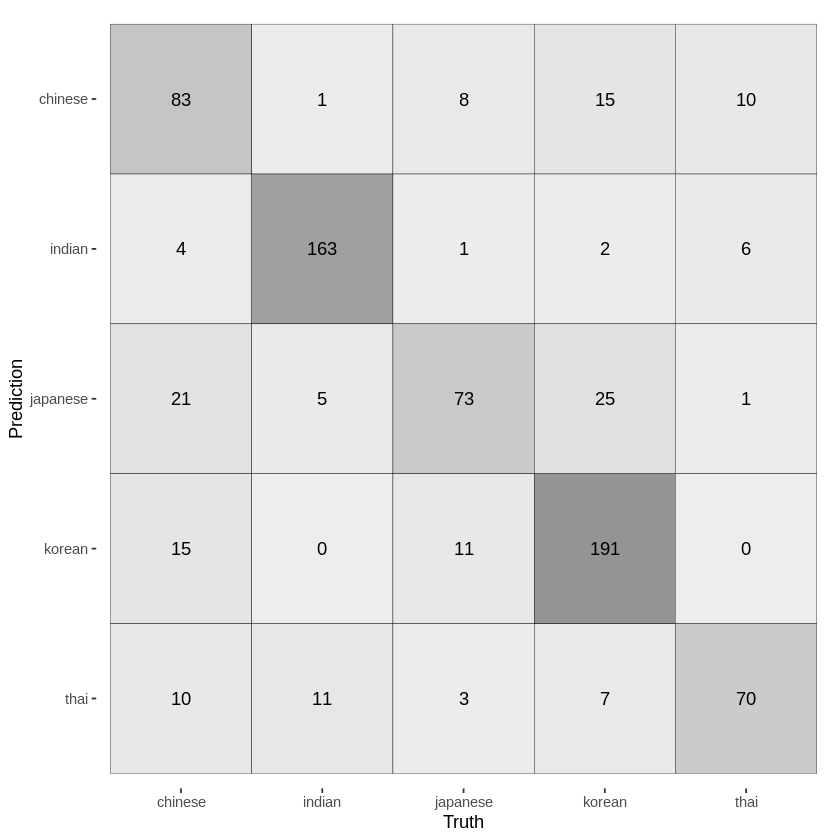

In [11]:
update_geom_defaults(geom = "tile", new = list(color = "black", alpha = 0.7))
# Visualize confusion matrix
results %>% 
  conf_mat(cuisine, .pred_class) %>% 
  autoplot(type = "heatmap")

Les cases plus foncées dans le graphique de la matrice de confusion indiquent un grand nombre de cas, et vous devriez normalement voir une ligne diagonale de cases plus foncées représentant les cas où l'étiquette prédite et l'étiquette réelle sont identiques.

Calculons maintenant les statistiques récapitulatives pour la matrice de confusion.


In [12]:
# Summary stats for confusion matrix
conf_mat(data = results, truth = cuisine, estimate = .pred_class) %>% 
summary()

.metric              .estimator .estimate
1  accuracy             multiclass 0.7880435
2  kap                  multiclass 0.7276583
3  sens                 macro      0.7780927
4  spec                 macro      0.9477598
5  ppv                  macro      0.7585583
6  npv                  macro      0.9460080
7  mcc                  multiclass 0.7292724
8  j_index              macro      0.7258524
9  bal_accuracy         macro      0.8629262
10 detection_prevalence macro      0.2000000
11 precision            macro      0.7585583
12 recall               macro      0.7780927
13 f_meas               macro      0.7641862

Si nous nous concentrons sur certains indicateurs comme la précision, la sensibilité, le ppv, nous ne sommes pas mal partis pour un début 🥳 !

## 4. Approfondir

Posons une question subtile : Quels critères sont utilisés pour choisir un type de cuisine donné comme résultat prédit ?

Eh bien, les algorithmes d'apprentissage automatique statistiques, comme la régression logistique, sont basés sur la `probabilité` ; ce qui est réellement prédit par un classificateur, c'est une distribution de probabilité sur un ensemble de résultats possibles. La classe avec la probabilité la plus élevée est alors choisie comme le résultat le plus probable pour les observations données.

Voyons cela en action en réalisant à la fois des prédictions de classes strictes et des probabilités.


In [13]:
# Make hard class prediction and probabilities
results_prob <- cuisines_test %>%
  select(cuisine) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test)) %>% 
  bind_cols(mr_fit %>% predict(new_data = cuisines_test, type = "prob"))

# Print out results
results_prob %>% 
  slice_head(n = 5)

cuisine .pred_class .pred_chinese .pred_indian .pred_japanese .pred_korean
1 indian  thai        1.551259e-03  0.4587877    5.988039e-04   2.428503e-04
2 indian  indian      2.637133e-05  0.9999488    6.648651e-07   2.259993e-05
3 indian  indian      1.049433e-03  0.9909982    1.060937e-03   1.644947e-05
4 indian  indian      6.237482e-02  0.4763035    9.136702e-02   3.660913e-01
5 indian  indian      1.431745e-02  0.9418551    2.945239e-02   8.721782e-03
  .pred_thai  
1 5.388194e-01
2 1.577948e-06
3 6.874989e-03
4 3.863391e-03
5 5.653283e-03

✅ Pouvez-vous expliquer pourquoi le modèle est assez sûr que la première observation est en thaï ?

## **🚀Défi**

Dans cette leçon, vous avez utilisé vos données nettoyées pour construire un modèle d'apprentissage automatique capable de prédire une cuisine nationale en fonction d'une série d'ingrédients. Prenez le temps de parcourir les [nombreuses options](https://www.tidymodels.org/find/parsnip/#models) que Tidymodels propose pour classifier les données et [d'autres méthodes](https://parsnip.tidymodels.org/articles/articles/Examples.html#multinom_reg-models) pour ajuster une régression multinomiale.

#### MERCI À :

[`Allison Horst`](https://twitter.com/allison_horst/) pour avoir créé les illustrations incroyables qui rendent R plus accueillant et engageant. Retrouvez plus d'illustrations dans sa [galerie](https://www.google.com/url?q=https://github.com/allisonhorst/stats-illustrations&sa=D&source=editors&ust=1626380772530000&usg=AOvVaw3zcfyCizFQZpkSLzxiiQEM).

[Cassie Breviu](https://www.twitter.com/cassieview) et [Jen Looper](https://www.twitter.com/jenlooper) pour avoir créé la version originale en Python de ce module ♥️

<br>
J'aurais bien ajouté quelques blagues, mais je ne comprends pas les jeux de mots culinaires 😅.

<br>

Bon apprentissage,

[Eric](https://twitter.com/ericntay), Gold Microsoft Learn Student Ambassador.



---

**Avertissement** :  
Ce document a été traduit à l'aide du service de traduction automatique [Co-op Translator](https://github.com/Azure/co-op-translator). Bien que nous nous efforcions d'assurer l'exactitude, veuillez noter que les traductions automatisées peuvent contenir des erreurs ou des inexactitudes. Le document original dans sa langue d'origine doit être considéré comme la source faisant autorité. Pour des informations critiques, il est recommandé de faire appel à une traduction humaine professionnelle. Nous déclinons toute responsabilité en cas de malentendus ou d'interprétations erronées résultant de l'utilisation de cette traduction.
